In [1]:
import numpy as np

import matplotlib.pyplot as plt
import msmtools
from tqdm.notebook import tqdm

import itertools
from pyemma.util.statistics import confidence_interval

In [2]:
def transition_matrix_3states(p, n_subsystems):
    """
    compiles a transition matrix of n independent 3 state systems.
    :param p: float, 0 <= p <= 1, transition probability to switch state
    :param n_subsystems: int, number of sub-systems
    :return: np.ndarray; reversible transition probability matrix
    """
    T_ = np.array([[(1-p), p/2, p/2],
                  [p/2, (1-p), p/2],
                  [p/2, p/2, (1-p)]])
    
    assert n_subsystems >= 2
    
    T = T_
    for _ in range(n_subsystems-1):
        T = np.kron(T_, T)
       
    assert msmtools.analysis.is_tmatrix(T)
    assert msmtools.analysis.is_reversible(T)
    return T

In [3]:
trials = 30
N = int(1e5)
eps = 0.1
n_systems = np.arange(2, 7)

In [4]:
sampled_independently = np.zeros((len(n_systems), trials), dtype=int)
sampled_combinatorics = np.zeros((len(n_systems), trials), dtype=int)
sampled_pairwise = np.zeros((len(n_systems), trials), dtype=int)

for _trial in tqdm(range(trials)):
    for num_subsys_n, num_subsys in enumerate(n_systems):
        T = transition_matrix_3states(eps, num_subsys)
        traj_comb = msmtools.generation.generate_traj(T, N)
        
        independent_trajs = list(np.unravel_index(traj_comb, tuple((3 for _ in range(num_subsys)))))
        
        # independent reversible sampling
        for fin_n, fin in enumerate(range(5, N, 5)):
            have_sampled_both_independently = True
            for n, t in enumerate(independent_trajs):
                c = msmtools.estimation.cmatrix(t[:fin], 1, sparse_return=False, nstates=3)

                if 0 in c.sum(axis=1):
                    have_sampled_both_independently = False
                    break

                T = msmtools.estimation.transition_matrix(c)
                have_sampled_both_independently *= msmtools.analysis.is_connected(T)
            if have_sampled_both_independently:
                sampled_independently[num_subsys_n, _trial] = fin
                break

        # all combinatorial state reversible sampling
        for fin_n, fin in enumerate(range(5, N, 5)):
            have_sampled_combinatorics = True
            c = msmtools.estimation.cmatrix(traj_comb[:fin], 1, sparse_return=False, nstates=3**num_subsys)
            if 0 in c.sum(axis=1):
                continue

            T = msmtools.estimation.transition_matrix(c)
            if msmtools.analysis.is_connected(T):
                sampled_combinatorics[num_subsys_n, _trial] = fin
                break
                
        # all pairwise reversible sampling
        for fin_n, fin in enumerate(range(5, N, 5)):
            have_sampled_pairwise = True
            for traj_a, traj_b in itertools.combinations(independent_trajs, 2):
                pairwise_traj_comb = np.ravel_multi_index(np.stack([traj_a, traj_b]), (3, 3))
                
                
                c = msmtools.estimation.cmatrix(pairwise_traj_comb[:fin], 1, sparse_return=False, nstates=9)
                if (0 in c.sum(axis=1)):
                    have_sampled_pairwise = False
                    break
                T = msmtools.estimation.transition_matrix(c)

                have_sampled_pairwise *= msmtools.analysis.is_connected(T)
            if have_sampled_pairwise:
                sampled_pairwise[num_subsys_n, _trial] = fin
                break

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
plt.matplotlib.rcParams['axes.titlesize'] = 12
plt.matplotlib.rcParams['axes.labelsize'] = 20
plt.matplotlib.rcParams['legend.fontsize'] = 11
plt.matplotlib.rcParams['xtick.labelsize'] = 11
plt.matplotlib.rcParams['ytick.labelsize'] = 11
plt.matplotlib.rcParams['xtick.minor.pad'] = 2
plt.matplotlib.rcParams['xtick.major.pad'] = 3
plt.matplotlib.rcParams['ytick.minor.pad'] = 2
plt.matplotlib.rcParams['ytick.major.pad'] = 3
plt.matplotlib.rcParams['axes.labelpad'] = 1
plt.matplotlib.rcParams['axes.labelsize'] = 11

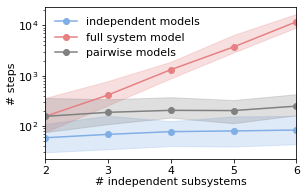

In [10]:
fig, ax = plt.subplots(figsize=(4.5, 2.8))
names = ['independent models', 'full system model', 'pairwise models']
colors = ['#80aee7ff', '#e68082ff', 'grey']
data = [sampled_independently, sampled_combinatorics, sampled_pairwise]
for _name, _data, _col in zip(names, data, colors):
    ax.plot(n_systems, _data.mean(axis=1), 'o-', label=_name, color=_col)
    l, h = confidence_interval(_data.T)
    ax.fill_between(n_systems, l, h, alpha=.25, color=_col)


ax.set_ylabel('# steps')
ax.set_xlabel('# independent subsystems')
ax.set_xticks(n_systems)
ax.set_xlim(n_systems[0] - .1, n_systems[-1] + .1)

ax.semilogy()
ax.legend(loc='upper left', frameon=False)
ax.set_xlim(2, 6)